In [1]:
import argparse
import cv2, os, glob
from collections import OrderedDict
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from maskrcnn_benchmark.config import cfg
from copy import deepcopy

IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

# red, green, blue, yellow, pink, sea, wite, green
color = [(255,0,0), (0,255,0),(0,0,255),\
         (255,255,0),(255,0,255),(0,255,255),(255,255,255),\
         (100,255,0),(100,0,255),(255,100,0),(0,100,255),(255,0,100),(0,255,100),(0,0,0)]
def get_color(i):
    m = len(color)
    return color[i] if i < m else color[i%m]

In [25]:
import argparse
import cv2, os, glob
from collections import OrderedDict
import torch
import numpy as np
from copy import deepcopy
from scipy import interpolate
from tqdm import tqdm
import logging

import maskrcnn_benchmark.engine.post_process as util
from maskrcnn_benchmark.utils.comm import synchronize, get_rank
import tools as tools


### input line: [[x0, x1...],...], [[y0, y1...]...]
### output: list[lines_info]
def create_polyline_for_lines(in_x, in_y, default_sample):
    lines_info = list()
    for i, (xl, yl) in enumerate(zip(in_x, in_y)): # for x/y list of each line
        if len(yl) <= 1:
            continue # drop 1 point line
        
        # ??? merge_point_with_same_y(yl,xl)
        
        y_max, y_min = max(yl), min(yl)

        yl, xl = np.array(yl), np.array(xl)
        ind = np.argsort(yl) # small->big
        yl, xl = yl[ind], xl[ind]

        pt_lower = np.array([ xl[-1], yl[-1] ])
        pt_upper = np.array([ xl[0], yl[0] ])
        
        # choose k
        if len(yl) <= 3:
            k = len(yl) - 1
            # print("pts len: {}, thus choose k: {}".format(len(yl), k))
            tck = interpolate.splrep(x=yl, y=xl, s=0, k=k)
        else:
            tck = interpolate.splrep(x=yl, y=xl, s=0)
        
        # create sampled y in range of (y_min, y_max)
        y_sample = default_sample[default_sample >= y_min]
        y_sample = y_sample[y_sample <= y_max]

        x_sample = interpolate.splev(x=y_sample, tck=tck, der=0)
        lines_info.append({
            'tck': tck,
            'y_max': y_max,
            'y_min': y_min,
            'pt_lower':pt_lower, # bound in lower image
            'pt_upper':pt_upper, # bound in upper image
        })
    return lines_info

# input line: list[lines_info]
# output: cluster of lines' id 
def merge_close_line(lines, thresh=15):
    result = list()
    selected = [False] * len(lines) # [False, ... False]
    for n in range(len(lines)):
        if selected[n]:
            continue
        result.append(list()) # create a new line (contain ids)
        result[-1].append(n)
        selected[n] = True
        for t in range(n + 1, len(lines)):
            if selected[t]:
                continue
            dis = compute_dist(lines[n], lines[t])
            if dis <= thresh: # find close line(t-th) of n-th line
                
                selected[t] = True 
                result[-1].append(t) # merge t-th lane
    return result


# input line: lines_info
def compute_dist(l1, l2):
    tck1 = l1['tck']
    tck2 = l2['tck']
    upper_bound = max(l1['y_min'], l2['y_min'])
    lower_bound = min(l1['y_max'], l2['y_max'])
    
    if upper_bound >= lower_bound:
        # seprated line
        # print("line seprated in y")
        if l1['y_max'] <= l2['y_min']:
            p1, p2 = l1['pt_lower'], l2['pt_upper']
            dist = np.sqrt(np.sum( (p1 - p2)**2 )) 
            return dist 
        elif l2['y_max'] <= l1['y_min']:
            p1, p2 = l2['pt_lower'], l1['pt_upper']
            dist = np.sqrt(np.sum( (p1 - p2)**2 ))
            return dist
        else:
            print("error")
            return 1e6
    else: 
        # overlaped line
        # print("overlaped line")
        ys_sample = np.arange(upper_bound, lower_bound, step=2.)
        xs_sample1 = interpolate.splev(x=ys_sample, tck=tck1, der=0)
        xs_sample2 = interpolate.splev(x=ys_sample, tck=tck2, der=0)
        dists = np.abs(xs_sample1 - xs_sample2)
        dist_sum = np.sum(dists) / len(ys_sample)
        return dist_sum


def eliminate_out(sorted_x, sorted_y, confidence = None, image = None):
    out_x = []
    out_y = []

    for lane_x, lane_y in zip(sorted_x, sorted_y):
        
        if len(lane_y) < 3:
            out_x.append(lane_x)
            out_y.append(lane_y)
            continue

        lane_x_along_y = np.array(deepcopy(lane_x))
        lane_y_along_y = np.array(deepcopy(lane_y))

        ind = np.argsort(lane_x_along_y, axis=0)
        lane_x_along_x = np.take_along_axis(lane_x_along_y, ind, axis=0)
        lane_y_along_x = np.take_along_axis(lane_y_along_y, ind, axis=0)
        
        if lane_y_along_x[0] > lane_y_along_x[-1]: #if y of left-end point is higher than right-end
            starting_points = [(lane_x_along_y[0], lane_y_along_y[0]), 
                               (lane_x_along_y[1], lane_y_along_y[1]), 
                               (lane_x_along_y[2], lane_y_along_y[2]),
                                (lane_x_along_x[0], lane_y_along_x[0]), 
                               (lane_x_along_x[1], lane_y_along_x[1]), 
                               (lane_x_along_x[2], lane_y_along_x[2])] # some low y, some left/right x
        else:
            starting_points = [(lane_x_along_y[0], lane_y_along_y[0]), 
                               (lane_x_along_y[1], lane_y_along_y[1]), 
                               (lane_x_along_y[2], lane_y_along_y[2]),
                                (lane_x_along_x[-1], lane_y_along_x[-1]), 
                               (lane_x_along_x[-2], lane_y_along_x[-2]), 
                               (lane_x_along_x[-3], lane_y_along_x[-3])] # some low y, some left/right x            
    
        temp_x = []
        temp_y = []
        for start_point in starting_points:
            temp_lane_x, temp_lane_y = generate_cluster(start_point, lane_x, lane_y, image)
            temp_x.append(temp_lane_x)
            temp_y.append(temp_lane_y)
        
        max_lenght_x = None
        max_lenght_y = None
        max_lenght = 0
        for i, j in zip(temp_x, temp_y):
            if len(i) > max_lenght:
                max_lenght = len(i)
                max_lenght_x = i
                max_lenght_y = j
        out_x.append(max_lenght_x)
        out_y.append(max_lenght_y)

    return out_x, out_y

# image is useless
def generate_cluster(start_point, lane_x, lane_y, image = None):
    cluster_x = [start_point[0]]
    cluster_y = [start_point[1]]

    point = start_point
    while True:
        points = util.get_closest_upper_point(lane_x, lane_y, point, 3)
         
        max_num = -1
        max_point = None

        if len(points) == 0:
            break
        if len(points) < 3:
            for i in points: 
                cluster_x.append(i[0])
                cluster_y.append(i[1])                
            break
        for i in points: 
            num, shortest = util.get_num_along_point(lane_x, lane_y, point, i, image)
            if max_num < num:
                max_num = num
                max_point = i

        total_remain = len(np.array(lane_y)[np.array(lane_y) < point[1]])
        cluster_x.append(max_point[0])
        cluster_y.append(max_point[1])
        point = max_point
        
        if len(points) == 1 or max_num < total_remain/5:
            break

    return cluster_x, cluster_y


def merge_point_with_same_y(in_x, in_y):
    new_in_x, new_in_y = list(), list()

    for lid, (xl, yl) in enumerate(zip(in_x, in_y)):
        new_xl, new_yl = list(), list()
        selected = [False] * len(yl)

        for i in range(len(yl)):
            if selected[i]:
                continue # ignore visited or merged point
            xi_sum = xl[i]
            xi_cnt = 1
            selected[i] = True

            for j in range(i+1, len(yl)):
                if selected[j]: # ignore merged point
                    continue
                if yl[j] == yl[i]: # merge this point
                    selected[j] = True
                    xi_sum += xl[j]
                    xi_cnt += 1
            new_yl.append(yl[i])
            new_xl.append(xi_sum / xi_cnt)
        if len(new_yl) <= 1:
            continue # ignore 1 point line
        new_in_x.append(new_xl)
        new_in_y.append(new_yl)
    return new_in_x, new_in_y


### input: lines[ line[ pt[x,y]... ]... ] and points sorted along y
def remove_close_points_orig(lines, rx, ry):
    xls = [[pt[0] for pt in line] for line in lines]
    yls = [[pt[1] for pt in line] for line in lines]
    
    xls, yls =merge_point_with_same_y(xls, yls)
    
    new_lines = list()
    for xl, yl in zip(xls, yls):
        if len(yl) <=2: # drop 2 points line
            continue
        
        if len(yl) <= 3:
            k = len(yl) - 1
            tck = interpolate.splrep(x=yl, y=xl, s=1, k=k)
        else:
            tck = interpolate.splrep(x=yl, y=xl, s=1, k=3)

        new_line = list()
        y_min, y_max = yl[0], yl[-1]
        if (y_max - y_min) <= 3.:
            ys_sample = np.array([y_min, y_max])
        else:
            ys_sample = np.arange(y_min, y_max, step=3.)

        xs_sample = interpolate.splev(x=ys_sample, tck=tck, der=0)
        new_line = [[x*rx, y*ry] for x,y in zip(xs_sample, ys_sample)]
        new_lines.append(new_line)
    return new_lines

from scipy.optimize import curve_fit
#def polyline(x, a, b, c, d, e, f):
#    return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f
#def polyline(x,a,b,c):
#    return a*np.exp(-b*x)-c

def remove_close_points(lines, rx, ry):
    xls = [[pt[0] for pt in line] for line in lines]
    yls = [[pt[1] for pt in line] for line in lines]
    
    xls, yls = merge_point_with_same_y(xls, yls)
    
    new_lines = list()
    for xl, yl in zip(xls, yls):
        if len(yl) <=2: # drop 2 points line
            continue
        

        new_line = list()
        y_min, y_max = yl[0], yl[-1]
        if (y_max - y_min) <= 3.:
            ys_sample = np.array([y_min, y_max])
        else:
            ys_sample = np.arange(y_min, y_max, step=3.)

        #xs_sample = interpolate.splev(x=ys_sample, tck=tck, der=0)
        #new_line = [[x*rx, y*ry] for x,y in zip(xs_sample, ys_sample)]
        #new_lines.append(new_line)
        
        
        #popt, pcov = curve_fit(polyline, xdata=yl, ydata=xl)
        #xs_sample = polyline(ys_sample, *popt)
        
        fitted = np.polyfit(yl, xl, 7)[::-1]
        xs_sample = np.zeros(len(ys_sample))
        for i in range(len(fitted)):
            xs_sample += fitted[i]*ys_sample**i

        new_line = [[x*rx, y*ry] for x,y in zip(xs_sample, ys_sample)]
        new_lines.append(new_line)
        
        
    return new_lines


def drop_short_line(in_x, in_y, thresh=60.):
    out_x, out_y = list(), list()
    for xl, yl in zip(in_x, in_y):
        dist = np.sqrt( (xl[0] - xl[-1])**2 + (yl[0] - yl[-1])**2 )
        if dist > thresh:
            out_x.append(xl)
            out_y.append(yl)
    return out_x, out_y


def add_pts_to_image_edge(lines):
    input_width = 1280-1
    input_height = 720-1
    interval = 3.2*2.5
    
    new_lines = list()
    for line in lines:
        x_pt_list = [pt[0] for pt in line]
        y_pt_list = [pt[1] for pt in line]

        max_y = y_pt_list[-1] # bottom pt
        if max_y < input_height: # 255
            y1 = y_pt_list[-2]
            y2 = y_pt_list[-1]
            x1 = x_pt_list[-2]
            x2 = x_pt_list[-1]

            # add points from points(max_y) to img bottom
            while max_y < input_height: # 255
                break_mark = False
                y_new = max_y + interval # 3.2(256/80)
                x_new = x1 + (x2 - x1) * (y_new - y1) / (y2 - y1)
                if x_new < 0:
                    x_new = 0.1
                    y_new = y1 + (y2 - y1) * (x_new - x1) / (x2 - x1)
                    break_mark = True
                elif x_new > input_width:
                    x_new = input_width
                    y_new = y1 + (y2 - y1) * (x_new - x1) / (x2 - x1)
                    break_mark = True
                if y_new > input_height :
                    y_new = input_height
                    x_new = x1 + (x2 - x1) * (y_new - y1) / (y2 - y1)
                    break_mark = True
                elif y_new < 0:
                    y_new = 0.1
                    x_new = x1 + (x2 - x1) * (y_new - y1) / (y2 - y1)
                    break_mark = True
                # check if x/y is valid
                #if ( x_new > input_width or x_new < 0 or y_new > input_height or y_new < 0):
                #    break
                x_pt_list.append(x_new)
                y_pt_list.append(y_new)
                max_y = y_new
                if break_mark:
                    break
        new_line = [[x,y] for x, y in zip(x_pt_list, y_pt_list)] 
        new_lines.append(new_line)
    return new_lines

In [3]:
cfg.merge_from_file('e2e_mask_rcnn_R_50_FPN_1x.yaml')
rx, ry = 1280/512., 720/256.
stride = 16.

In [4]:
###################### big
outputs_dict = torch.load("exp/oct23/inference/aicom_lane_test/oct23_res04_r0.pth", 
                          map_location=torch.device("cpu")) 
pred = outputs_dict["predictions"]
test_imgs = outputs_dict["test_images"]
def get_imgs(idx):
    return cv2.imread(test_imgs[idx])

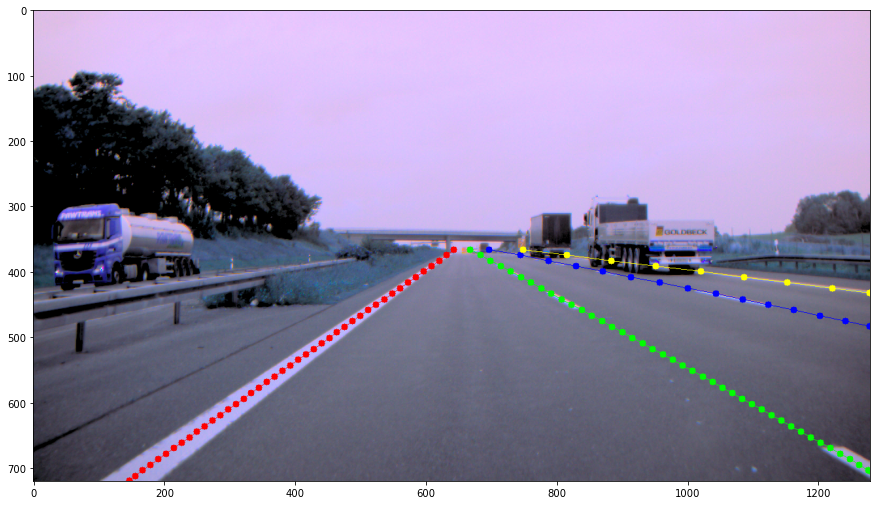

In [28]:
### input lines[ un-sorted line[ pt[x,y]... ]... ] 
# prediction, rx, ry, stride=16.
idx = 7995  # 11278 10881 10646 10569 9238 9230 9129 9113 8732 8510
prediction = pred[idx]

### 1. 
outlines = list()
for i, group in enumerate(prediction):
    outline = list()
    for line in group:
        outline.extend(line)
    outlines.append(outline)

### 2.1 eliminate outlier
x_lines = [[pt[0] for pt in line] for line in outlines]
y_lines = [[pt[1] for pt in line] for line in outlines]
in_x, in_y = util.sort_along_y(x_lines, y_lines)
in_x, in_y = eliminate_out(in_x, in_y)
### 2.2 merge point with same y
in_x, in_y = util.sort_along_y_asc(in_x, in_y)
in_x, in_y = merge_point_with_same_y(in_x, in_y)
### 2.3 drop short line
in_x, in_y = drop_short_line(in_x, in_y, thresh=60.)

### 3. merge close line
### 3.1 create polyline for each line
default_sample = np.arange(0., 256., step=3.)
lines_info = create_polyline_for_lines(in_x, in_y, default_sample)
### 3.2 find and merge close line
lid_cluster = merge_close_line(lines_info)
# output lines format lines[line[point[x,y],...],...]
regrouped_lines = list()
for i, lids in enumerate(lid_cluster):
    temp = list()
    for lid in lids:
        xl, yl = in_x[lid], in_y[lid]
        temp.extend([[x, y] for x, y in zip(xl, yl)])
    # sort along y
    temp = sorted(temp, key=lambda pt: pt[1])
    regrouped_lines.append(temp)

### 4. remove close points
# print(regrouped_lines)
# print("\n")
final_lines = remove_close_points(regrouped_lines, rx, ry)
# print(final_lines)

final_lines = add_pts_to_image_edge(final_lines)

lines = final_lines

im = get_imgs(idx)
'''
for i, line in enumerate(lines):
    for pt in line:
        x,y = int(pt[0]), int(pt[1])
        # x,y = int(pt[0]*rx), int(pt[1]*ry)
        cv2.circle(im, (x,y), 3, get_color(i), -1) 
'''        
for lid, pts in enumerate(lines):

    for i in range(len(pts)-1):
        x1 = int(pts[i][0])
        y1 = int(pts[i][1])
        x2 = int(pts[i+1][0])
        y2 = int(pts[i+1][1])
        cv2.circle(im, (x1,y1), 5, color[lid], -1)
        cv2.circle(im, (x2,y2), 5, color[lid], -1)
        cv2.line(im, (x1,y1), (x2,y2), color[lid], 1)
        
plt.figure(figsize=(15, 15))
plt.imshow(im)
plt.show() 